Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!
Dataset Shape: (5000, 26)

First few rows:
  TransactionID AccountID  TransactionAmount   TransactionDate  \
0      TX000001   AC00886            1229.04  17/08/2023 12:55   
1      TX000002   AC00809             546.65  07/11/2023 10:32   
2      TX000003   AC00262            2803.81  16/05/2024 06:33   
3      TX000004   AC00725            2871.02  24/07/2023 02:39   
4      TX000005   AC00804            1271.12  29/01/2023 16:08   

  TransactionType     Location DeviceID      IP Address MerchantID Channel  \
0          Credit       Austin  D000345    46.69.138.33       M020     ATM   
1      Withdrawal  Los Angeles  D000593  169.93.230.192       M041     ATM   
2      Withdrawal     New York  D000743  234.207.36.205       M065  Branch   
3        Transfer       Boston  D000712    47.39.12.193       M053  Branch   
4          Credit    San Diego  D000034    148.234.5.84       M096 

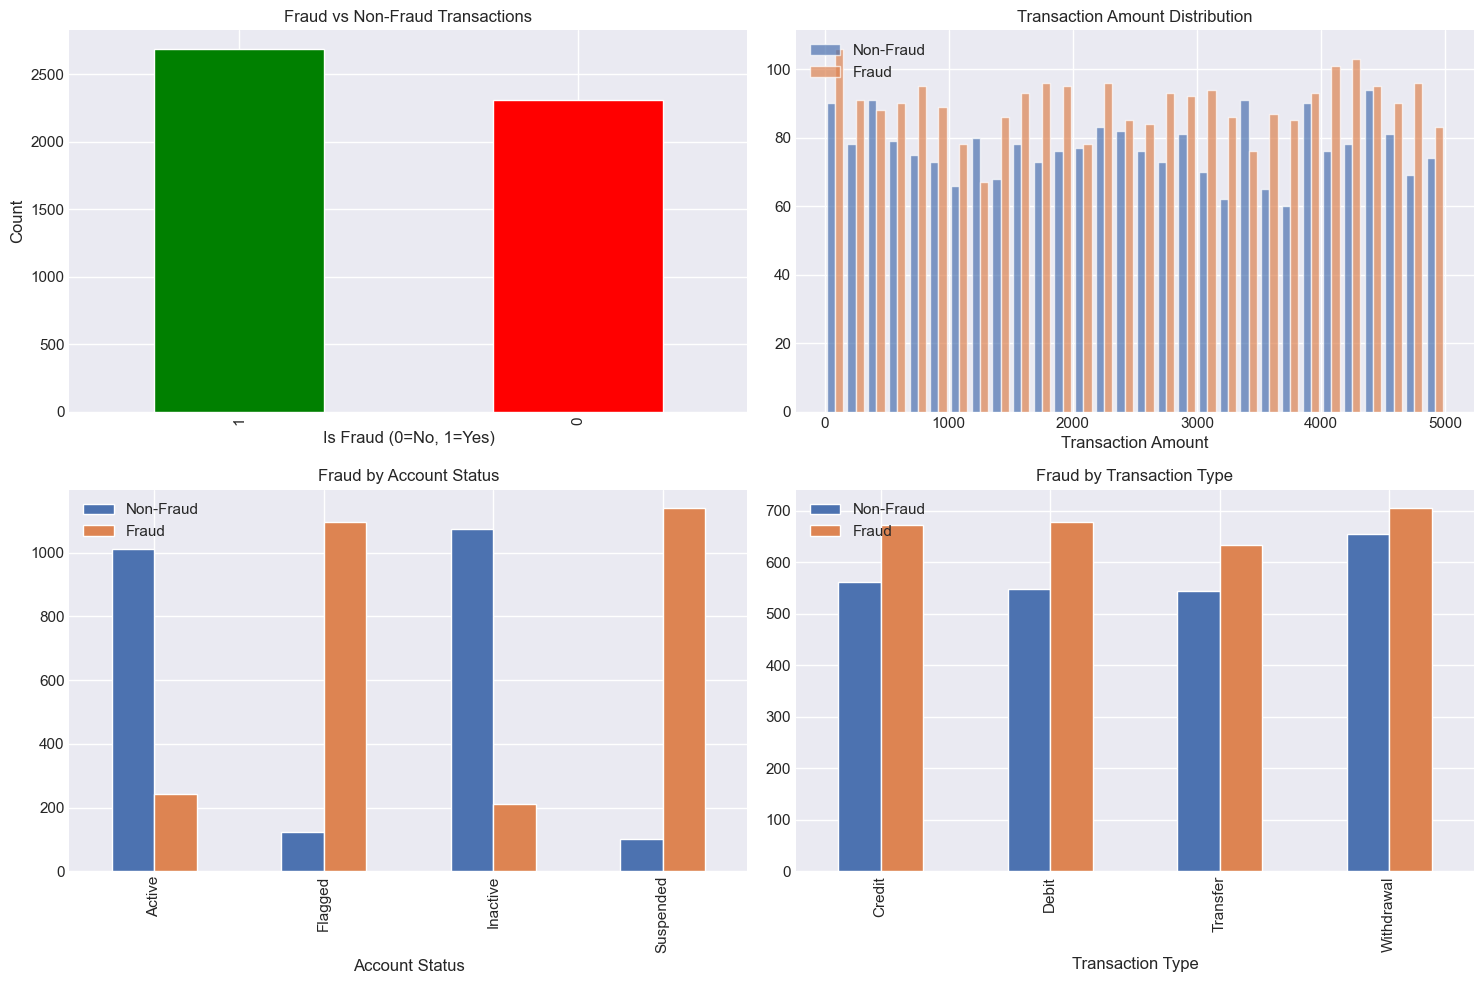


Fraud Statistics by Category:

1. By Account Status:
                 sum      mean
Account Status                
Active           242  0.192982
Flagged         1098  0.899263
Inactive         210  0.163551
Suspended       1141  0.919420

2. By Transaction Type:
                 sum      mean
TransactionType               
Credit           672  0.545012
Debit            679  0.552932
Transfer         634  0.538200
Withdrawal       706  0.518736

3. By Channel:
         sum      mean
Channel               
ATM      524  0.528759
Branch   563  0.560757
Mobile   533  0.524606
Online   533  0.535141
POS      538  0.541793

Feature Matrix Shape: (5000, 26)
Target Distribution:
IsFraud
1    2691
0    2309
Name: count, dtype: int64

Top 15 Important Features:
                      Feature  Importance
13             Account Status    0.385629
7               LoginAttempts    0.083964
16    Invalid pin retry count    0.080222
14         Invalid Pin Status    0.074139
23       AmountToBalanceR

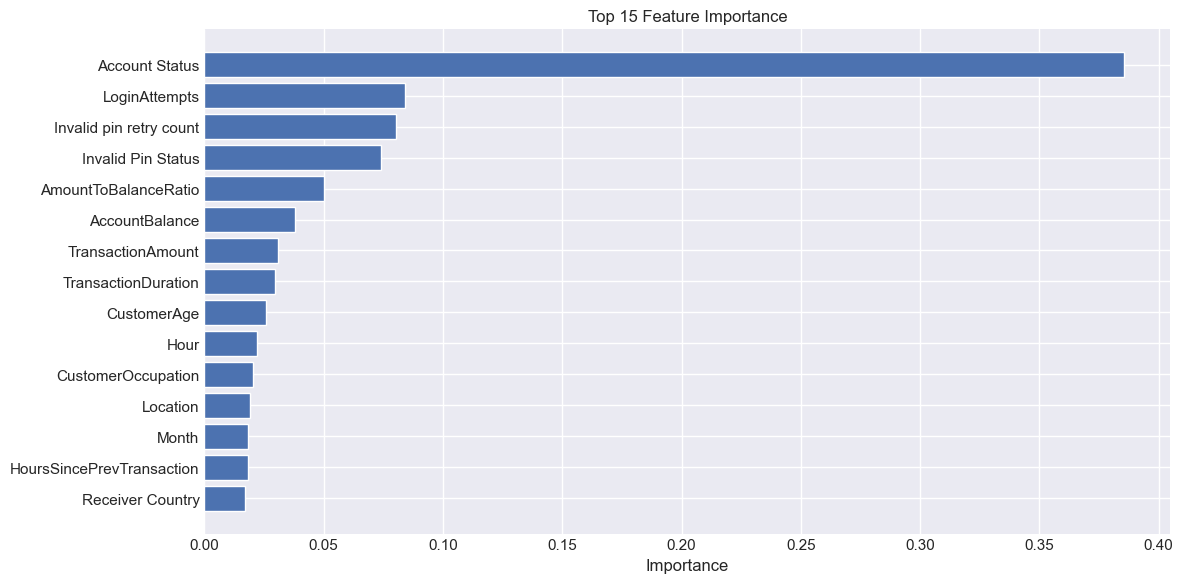


Training Set: (4000, 26), Fraud: 2153
Test Set: (1000, 26), Fraud: 538

Scaling Complete!

After SMOTE - Training Set: (4306, 26)
Balanced Class Distribution:
IsFraud
1    2153
0    2153
Name: count, dtype: int64

TRAINING MODELS

Training Logistic Regression...

Logistic Regression Results:
Accuracy:  0.7130
Precision: 0.7475
Recall:    0.7045
F1-Score:  0.7254
ROC-AUC:   0.7854

Training Decision Tree...

Decision Tree Results:
Accuracy:  0.9950
Precision: 0.9981
Recall:    0.9926
F1-Score:  0.9953
ROC-AUC:   0.9952

Training Random Forest...

Random Forest Results:
Accuracy:  0.9900
Precision: 0.9889
Recall:    0.9926
F1-Score:  0.9907
ROC-AUC:   0.9989

Training Gradient Boosting...

Gradient Boosting Results:
Accuracy:  0.9940
Precision: 0.9981
Recall:    0.9907
F1-Score:  0.9944
ROC-AUC:   0.9994

MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression     0.713   0.747535 0.704461  0.725359 0.785356
      Decision Tree     0.995

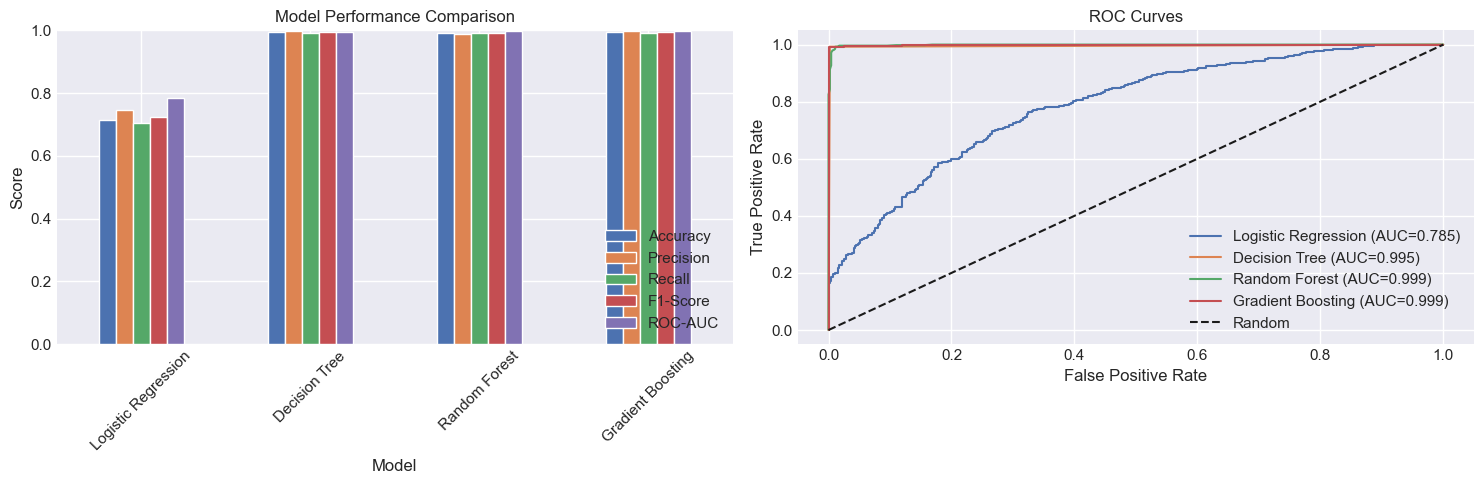


BEST MODEL: Decision Tree


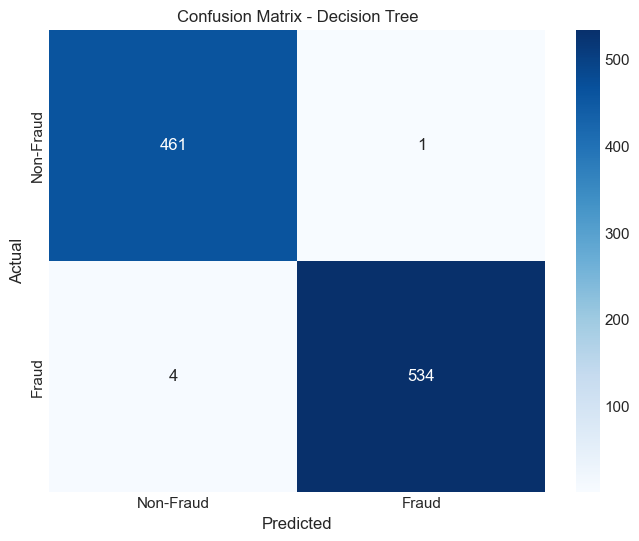


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      0.99       462
       Fraud       1.00      0.99      1.00       538

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


Model saved as: fraud_detection_model_decision_tree.pkl
Scaler saved as: scaler.pkl
Label encoders saved as: label_encoders.pkl

MODEL TRAINING COMPLETE!

Best Model: Decision Tree
F1-Score: 0.9953
Recall: 0.9926
Precision: 0.9981

You can now use this model to detect fraudulent transactions!


In [26]:
# Bank Transaction Fraud Detection Model
# Complete Jupyter Notebook Implementation

%pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("All libraries imported successfully!")

# ============================================================================
# STEP 1: LOAD AND EXPLORE DATA
# ============================================================================

# Load the dataset
df = pd.read_csv('fraud_detection_training_data-5000.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nColumn Names:")
print(df.columns.tolist())

# ============================================================================
# STEP 2: CREATE FRAUD LABEL (TARGET VARIABLE)
# ============================================================================

# Based on the data, we'll create fraud indicators using multiple suspicious patterns
def create_fraud_label(row):
    """
    Create fraud label based on multiple suspicious indicators:
    - Account Status: Flagged or Suspended
    - Invalid Pin Status: Invalid or Locked
    - Multiple login attempts (>3)
    - Low account balance relative to transaction
    - High invalid pin retry count
    """
    fraud_score = 0
    
    # Flagged or Suspended accounts
    if row['Account Status'] in ['Flagged', 'Suspended']:
        fraud_score += 2
    
    # Invalid or Locked pin status
    if row['Invalid Pin Status'] in ['Invalid', 'Locked']:
        fraud_score += 1
    
    # Multiple login attempts
    if row['LoginAttempts'] >= 4:
        fraud_score += 1
    
    # High invalid pin retry count
    if row['Invalid pin retry count'] >= 2:
        fraud_score += 1
    
    # Low balance for transaction (balance < 2x transaction)
    if row['AccountBalance'] < (2 * row['TransactionAmount']):
        fraud_score += 1
    
    # Consider fraud if score >= 3
    return 1 if fraud_score >= 3 else 0

df['IsFraud'] = df.apply(create_fraud_label, axis=1)

print("\nFraud Distribution:")
print(df['IsFraud'].value_counts())
print(f"\nFraud Percentage: {df['IsFraud'].mean() * 100:.2f}%")

# ============================================================================
# STEP 3: DATA PREPROCESSING
# ============================================================================

# Convert date column to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%Y %H:%M')
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], 
                                                format='%d/%m/%Y %H:%M', 
                                                errors='coerce')

# Extract date features
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
df['Month'] = df['TransactionDate'].dt.month
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)

# Calculate time since previous transaction (in hours)
df['HoursSincePrevTransaction'] = (
    (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 3600
)
df['HoursSincePrevTransaction'].fillna(df['HoursSincePrevTransaction'].median(), inplace=True)

# Transaction amount to balance ratio
df['AmountToBalanceRatio'] = df['TransactionAmount'] / (df['AccountBalance'] + 1)

# Cross-border transaction flag
df['IsCrossBorder'] = (df['Sender Country'] != df['Receiver Country']).astype(int)

# Currency mismatch flag
df['IsCurrencyMismatch'] = (df['Sender Currency'] != df['Receiver Currency']).astype(int)

# Handle missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print("\nFeature Engineering Complete!")
print(f"Total Features: {df.shape[1]}")

# ============================================================================
# STEP 4: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

# Fraud distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Fraud Distribution
df['IsFraud'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'red'])
axes[0,0].set_title('Fraud vs Non-Fraud Transactions')
axes[0,0].set_xlabel('Is Fraud (0=No, 1=Yes)')
axes[0,0].set_ylabel('Count')

# Plot 2: Transaction Amount Distribution
axes[0,1].hist([df[df['IsFraud']==0]['TransactionAmount'], 
                df[df['IsFraud']==1]['TransactionAmount']], 
               label=['Non-Fraud', 'Fraud'], bins=30, alpha=0.7)
axes[0,1].set_title('Transaction Amount Distribution')
axes[0,1].set_xlabel('Transaction Amount')
axes[0,1].legend()

# Plot 3: Fraud by Account Status
pd.crosstab(df['Account Status'], df['IsFraud']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Fraud by Account Status')
axes[1,0].set_xlabel('Account Status')
axes[1,0].legend(['Non-Fraud', 'Fraud'])

# Plot 4: Fraud by Transaction Type
pd.crosstab(df['TransactionType'], df['IsFraud']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Fraud by Transaction Type')
axes[1,1].set_xlabel('Transaction Type')
axes[1,1].legend(['Non-Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

# Additional Analysis
print("\nFraud Statistics by Category:")
print("\n1. By Account Status:")
print(df.groupby('Account Status')['IsFraud'].agg(['sum', 'mean']))

print("\n2. By Transaction Type:")
print(df.groupby('TransactionType')['IsFraud'].agg(['sum', 'mean']))

print("\n3. By Channel:")
print(df.groupby('Channel')['IsFraud'].agg(['sum', 'mean']))

# ============================================================================
# STEP 5: FEATURE SELECTION AND PREPARATION
# ============================================================================

# Select features for modeling
features_to_drop = ['TransactionID', 'AccountID', 'TransactionDate', 
                    'PreviousTransactionDate', 'DeviceID', 'IP Address',
                    'Sender Account', 'Receiver Account', 'MerchantID']

# Encode categorical variables
categorical_cols = ['TransactionType', 'Location', 'Channel', 
                    'CustomerOccupation', 'Sender Country', 'Receiver Country',
                    'Sender Currency', 'Receiver Currency', 'Account Status',
                    'Invalid Pin Status']

le_dict = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le

# Prepare features and target
X = df_encoded.drop(features_to_drop + ['IsFraud'], axis=1, errors='ignore')
y = df_encoded['IsFraud']

print("\nFeature Matrix Shape:", X.shape)
print("Target Distribution:")
print(y.value_counts())

# Feature importance analysis (using a quick Random Forest)
rf_quick = RandomForestClassifier(n_estimators=50, random_state=42)
rf_quick.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_quick.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance.head(15)['Feature'], feature_importance.head(15)['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: TRAIN-TEST SPLIT AND SCALING
# ============================================================================

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape}, Fraud: {y_train.sum()}")
print(f"Test Set: {X_test.shape}, Fraud: {y_test.sum()}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling Complete!")

# ============================================================================
# STEP 7: HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================================================

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE - Training Set: {X_train_balanced.shape}")
print("Balanced Class Distribution:")
print(pd.Series(y_train_balanced).value_counts())

# ============================================================================
# STEP 8: TRAIN MULTIPLE MODELS
# ============================================================================

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

# ============================================================================
# STEP 9: MODEL COMPARISON AND EVALUATION
# ============================================================================

# Create results dataframe
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results.keys()],
    'Precision': [results[m]['Precision'] for m in results.keys()],
    'Recall': [results[m]['Recall'] for m in results.keys()],
    'F1-Score': [results[m]['F1-Score'] for m in results.keys()],
    'ROC-AUC': [results[m]['ROC-AUC'] for m in results.keys()]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of metrics
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1])

# ROC Curves
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['Probabilities'])
    axes[1].plot(fpr, tpr, label=f"{name} (AUC={results[name]['ROC-AUC']:.3f})")

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 10: DETAILED EVALUATION OF BEST MODEL
# ============================================================================

# Select best model based on F1-Score (balanced metric for fraud detection)
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_model = results[best_model_name]['Model']

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*70}")

# Confusion Matrix
cm = confusion_matrix(y_test, results[best_model_name]['Predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, results[best_model_name]['Predictions'],
                          target_names=['Non-Fraud', 'Fraud']))

# ============================================================================
# STEP 11: SAVE THE MODEL
# ============================================================================

import pickle
import joblib

# Save the best model
model_filename = f'fraud_detection_model_{best_model_name.replace(" ", "_").lower()}.pkl'


with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(le_dict, f)

#save using joblib as well
joblib.dump(best_model, model_filename.replace('.pkl', '.joblib'))  
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le_dict, 'label_encoders.joblib')


print(f"\nModel saved as: {model_filename}")
print("Scaler saved as: scaler.pkl")
print("Label encoders saved as: label_encoders.pkl")

# ============================================================================
# STEP 12: FUNCTION TO PREDICT NEW TRANSACTIONS
# ============================================================================

def predict_fraud(transaction_data):
    """
    Predict if a transaction is fraudulent
    
    Parameters:
    transaction_data: dictionary or DataFrame with transaction features
    
    Returns:
    prediction (0 or 1) and probability of fraud
    """
    # Load models
    with open(model_filename, 'rb') as f:
        model = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('label_encoders.pkl', 'rb') as f:
        le_dict = pickle.load(f)
    
    # Preprocess the transaction
    # (Add your preprocessing logic here)
    
    # Scale features
    transaction_scaled = scaler.transform(transaction_data)
    
    # Predict
    prediction = model.predict(transaction_scaled)[0]
    probability = model.predict_proba(transaction_scaled)[0][1]
    
    return prediction, probability

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE!")
print("="*70)
print(f"\nBest Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['F1-Score']:.4f}")
print(f"Recall: {results[best_model_name]['Recall']:.4f}")
print(f"Precision: {results[best_model_name]['Precision']:.4f}")
print("\nYou can now use this model to detect fraudulent transactions!")

In [24]:
# Fraud Detection Model Testing Script - FIXED VERSION
# Test your trained model with sample transactions

import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("FRAUD DETECTION MODEL - TESTING SCRIPT")
print("="*70)

# ============================================================================
# STEP 1: LOAD THE SAVED MODELS WITH ERROR HANDLING
# ============================================================================

def load_models():
    """Load all saved model components with better error handling"""
    model, scaler, le_dict = None, None, None
    
    # Try different model filenames
    model_files = [
        'fraud_detection_model_random_forest.pkl',
        'fraud_detection_model_gradient_boosting.pkl',
        'fraud_detection_model_logistic_regression.pkl',
        'fraud_detection_model_decision_tree.pkl'
    ]
    
    for model_file in model_files:
        try:
            with open(model_file, 'rb') as f:
                model = pickle.load(f)
            print(f"✓ Model loaded successfully: {model_file}")
            break
        except FileNotFoundError:
            continue
    
    if model is None:
        print("\n❌ Error: No trained model found!")
        print("Please run the training script first to create the model.")
        print("Expected files: fraud_detection_model_*.pkl")
        return None, None, None
    
    try:
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("✓ Scaler loaded successfully")
    except FileNotFoundError:
        print("❌ Error: scaler.pkl not found!")
        return None, None, None
    
    try:
        with open('label_encoders.pkl', 'rb') as f:
            le_dict = pickle.load(f)
        print("✓ Label encoders loaded successfully")
    except FileNotFoundError:
        print("❌ Error: label_encoders.pkl not found!")
        return None, None, None
    
    return model, scaler, le_dict

model, scaler, le_dict = load_models()

# Exit if models couldn't be loaded
if model is None or scaler is None or le_dict is None:
    print("\n⚠️  Cannot proceed without trained models. Exiting...")
    exit()

# ============================================================================
# STEP 2: CREATE SAMPLE TEST TRANSACTIONS
# ============================================================================

def create_sample_transactions():
    """Create sample transactions for testing (mix of normal and suspicious)"""
    
    samples = [
        # Transaction 1: NORMAL - Small withdrawal from active account
        {
            'TransactionAmount': 150.00,
            'TransactionDate': '15/09/2024 14:30',
            'TransactionType': 'Withdrawal',
            'Location': 'New York',
            'Channel': 'ATM',
            'CustomerAge': 35,
            'CustomerOccupation': 'Teacher',
            'TransactionDuration': 45,
            'LoginAttempts': 1,
            'AccountBalance': 5000.00,
            'PreviousTransactionDate': '10/09/2024 10:20',
            'Sender Country': 'USA',
            'Receiver Country': 'USA',
            'Sender Currency': 'USD',
            'Receiver Currency': 'USD',
            'Account Status': 'Active',
            'Invalid Pin Status': 'Valid',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 0
        },
        
        # Transaction 2: SUSPICIOUS - Flagged account with high retry count
        {
            'TransactionAmount': 3500.00,
            'TransactionDate': '16/09/2024 02:15',
            'TransactionType': 'Transfer',
            'Location': 'Miami',
            'Channel': 'Online',
            'CustomerAge': 28,
            'CustomerOccupation': 'Student',
            'TransactionDuration': 180,
            'LoginAttempts': 5,
            'AccountBalance': 4200.00,
            'PreviousTransactionDate': '15/09/2024 23:45',
            'Sender Country': 'USA',
            'Receiver Country': 'Germany',
            'Sender Currency': 'USD',
            'Receiver Currency': 'EUR',
            'Account Status': 'Flagged',
            'Invalid Pin Status': 'Locked',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 3
        },
        
        # Transaction 3: SUSPICIOUS - Suspended account, low balance
        {
            'TransactionAmount': 8000.00,
            'TransactionDate': '17/09/2024 03:30',
            'TransactionType': 'Transfer',
            'Location': 'Los Angeles',
            'Channel': 'Mobile',
            'CustomerAge': 22,
            'CustomerOccupation': 'Student',
            'TransactionDuration': 200,
            'LoginAttempts': 4,
            'AccountBalance': 1500.00,
            'PreviousTransactionDate': 'NaN/NaN/NaN NaN:NaN',
            'Sender Country': 'USA',
            'Receiver Country': 'Germany',
            'Sender Currency': 'USD',
            'Receiver Currency': 'GBP',
            'Account Status': 'Suspended',
            'Invalid Pin Status': 'Invalid',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 2
        },
        
        # Transaction 4: NORMAL - Regular credit transaction
        {
            'TransactionAmount': 2500.00,
            'TransactionDate': '18/09/2024 11:00',
            'TransactionType': 'Credit',
            'Location': 'Boston',
            'Channel': 'Branch',
            'CustomerAge': 45,
            'CustomerOccupation': 'Engineer',
            'TransactionDuration': 30,
            'LoginAttempts': 1,
            'AccountBalance': 15000.00,
            'PreviousTransactionDate': '12/09/2024 14:20',
            'Sender Country': 'USA',
            'Receiver Country': 'USA',
            'Sender Currency': 'USD',
            'Receiver Currency': 'USD',
            'Account Status': 'Active',
            'Invalid Pin Status': 'Valid',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 0
        },
        
        # Transaction 5: VERY SUSPICIOUS - Night transaction, cross-border, locked PIN
        {
            'TransactionAmount': 5000.00,
            'TransactionDate': '19/09/2024 23:45',
            'TransactionType': 'Transfer',
            'Location': 'Chicago',
            'Channel': 'Online',
            'CustomerAge': 19,
            'CustomerOccupation': 'Student',
            'TransactionDuration': 250,
            'LoginAttempts': 6,
            'AccountBalance': 5500.00,
            'PreviousTransactionDate': '19/09/2024 23:30',
            'Sender Country': 'USA',
            'Receiver Country': 'Canada',
            'Sender Currency': 'USD',
            'Receiver Currency': 'EUR',
            'Account Status': 'Flagged',
            'Invalid Pin Status': 'Locked',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 3
        },
        
        # Transaction 6: NORMAL - Regular POS purchase
        {
            'TransactionAmount': 85.50,
            'TransactionDate': '20/09/2024 18:20',
            'TransactionType': 'Debit',
            'Location': 'Seattle',
            'Channel': 'POS',
            'CustomerAge': 38,
            'CustomerOccupation': 'Doctor',
            'TransactionDuration': 25,
            'LoginAttempts': 1,
            'AccountBalance': 12000.00,
            'PreviousTransactionDate': '18/09/2024 12:30',
            'Sender Country': 'USA',
            'Receiver Country': 'USA',
            'Sender Currency': 'USD',
            'Receiver Currency': 'USD',
            'Account Status': 'Active',
            'Invalid Pin Status': 'Valid',
            'Invalid pin retry limits': 3,
            'Invalid pin retry count': 0
        }
    ]
    
    return pd.DataFrame(samples)

# Create sample transactions
test_df = create_sample_transactions()
print(f"\n✓ Created {len(test_df)} sample transactions for testing\n")

# ============================================================================
# STEP 3: PREPROCESS TEST DATA (SAME AS TRAINING) - FIXED VERSION
# ============================================================================

def preprocess_transaction(df):
    """Apply the same preprocessing as training with better error handling"""
    
    df = df.copy()
    
    # Convert dates
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], 
                                           format='%d/%m/%Y %H:%M',
                                           errors='coerce')
    df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], 
                                                    format='%d/%m/%Y %H:%M', 
                                                    errors='coerce')
    
    # Extract time features
    df['Hour'] = df['TransactionDate'].dt.hour
    df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
    df['Month'] = df['TransactionDate'].dt.month
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)
    
    # Time since previous transaction - handle NaN properly
    df['HoursSincePrevTransaction'] = (
        (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 3600
    )
    # Fill NaN with median or a large value
    median_hours = df['HoursSincePrevTransaction'].median()
    if pd.isna(median_hours):
        median_hours = 168  # Default to 1 week if no valid previous transactions
    df['HoursSincePrevTransaction'].fillna(median_hours, inplace=True)
    
    # Additional features
    df['AmountToBalanceRatio'] = df['TransactionAmount'] / (df['AccountBalance'] + 1)
    df['IsCrossBorder'] = (df['Sender Country'] != df['Receiver Country']).astype(int)
    df['IsCurrencyMismatch'] = (df['Sender Currency'] != df['Receiver Currency']).astype(int)
    
    # Encode categorical variables with better error handling
    categorical_cols = ['TransactionType', 'Location', 'Channel', 
                        'CustomerOccupation', 'Sender Country', 'Receiver Country',
                        'Sender Currency', 'Receiver Currency', 'Account Status',
                        'Invalid Pin Status']
    
    for col in categorical_cols:
        if col in df.columns:
            if col in le_dict:
                # Handle unknown categories by mapping to most common class
                known_classes = set(le_dict[col].classes_)
                df[col] = df[col].apply(
                    lambda x: x if x in known_classes else le_dict[col].classes_[0]
                )
                df[col] = le_dict[col].transform(df[col].astype(str))
            else:
                print(f"⚠️  Warning: No encoder found for {col}, using default encoding")
                df[col] = pd.Categorical(df[col]).codes
    
    # Drop non-feature columns
    features_to_drop = ['TransactionDate', 'PreviousTransactionDate']
    df = df.drop(features_to_drop, axis=1, errors='ignore')
    
    # Ensure all required columns exist and fill any remaining NaN
    df = df.fillna(0)
    
    return df

# Preprocess test data with error handling
try:
    test_processed = preprocess_transaction(test_df)
    print("✓ Test data preprocessed successfully")
    print(f"  Shape: {test_processed.shape}")
    print(f"  Columns: {list(test_processed.columns)}\n")
except Exception as e:
    print(f"❌ Error during preprocessing: {str(e)}")
    print("Please check your data format and try again.")
    exit()

# ============================================================================
# STEP 4: MAKE PREDICTIONS WITH ERROR HANDLING
# ============================================================================

def predict_fraud_batch(transactions_df):
    """Predict fraud for multiple transactions with error handling"""
    
    try:
        # Get feature names from scaler if available
        expected_features = None
        if hasattr(scaler, 'n_features_in_'):
            expected_features = scaler.n_features_in_
            print(f"  Expected features: {expected_features}")
            print(f"  Provided features: {transactions_df.shape[1]}")
            
            if transactions_df.shape[1] != expected_features:
                print(f"⚠️  Warning: Feature count mismatch!")
                print(f"  Expected: {expected_features}, Got: {transactions_df.shape[1]}")
        
        # Scale features
        X_test = scaler.transform(transactions_df)
        
        # Make predictions
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)[:, 1]
        
        return predictions, probabilities
    
    except Exception as e:
        print(f"❌ Error during prediction: {str(e)}")
        print(f"Transaction DataFrame shape: {transactions_df.shape}")
        print(f"Transaction DataFrame columns: {list(transactions_df.columns)}")
        raise

# Get predictions
try:
    predictions, probabilities = predict_fraud_batch(test_processed)
    print("✓ Predictions generated successfully\n")
except Exception as e:
    print(f"❌ Failed to make predictions: {str(e)}")
    exit()

# ============================================================================
# STEP 5: DISPLAY RESULTS
# ============================================================================

print("="*70)
print("PREDICTION RESULTS")
print("="*70)

results_df = test_df[['TransactionAmount', 'TransactionType', 'Account Status', 
                      'Invalid Pin Status', 'LoginAttempts']].copy()
results_df['Fraud_Prediction'] = predictions
results_df['Fraud_Probability'] = (probabilities * 100).round(2)
results_df['Risk_Level'] = pd.cut(probabilities, 
                                   bins=[0, 0.3, 0.6, 1.0],
                                   labels=['Low', 'Medium', 'High'])

# Display each transaction
for idx, row in results_df.iterrows():
    print(f"\n{'─'*70}")
    print(f"TRANSACTION #{idx + 1}")
    print(f"{'─'*70}")
    print(f"Amount:              ${row['TransactionAmount']:,.2f}")
    print(f"Type:                {test_df.loc[idx, 'TransactionType']}")
    print(f"Account Status:      {test_df.loc[idx, 'Account Status']}")
    print(f"PIN Status:          {test_df.loc[idx, 'Invalid Pin Status']}")
    print(f"Login Attempts:      {row['LoginAttempts']}")
    print(f"\n{'─'*30}")
    
    if row['Fraud_Prediction'] == 1:
        print(f"⚠️  PREDICTION:        FRAUD DETECTED")
        print(f"🔴 Risk Level:        {row['Risk_Level']}")
        print(f"📊 Fraud Probability: {row['Fraud_Probability']:.2f}%")
        print(f"{'─'*30}")
        print("🚨 ACTION REQUIRED: Review this transaction immediately!")
    else:
        print(f"✅ PREDICTION:        LEGITIMATE")
        print(f"🟢 Risk Level:        {row['Risk_Level']}")
        print(f"📊 Fraud Probability: {row['Fraud_Probability']:.2f}%")
        print(f"{'─'*30}")
        print("✓ Transaction appears safe to proceed.")

# Summary statistics
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"Total Transactions:   {len(results_df)}")
print(f"Flagged as Fraud:     {predictions.sum()}")
print(f"Marked as Legitimate: {len(predictions) - predictions.sum()}")
print(f"Average Fraud Risk:   {probabilities.mean() * 100:.2f}%")

# ============================================================================
# STEP 6: FUNCTION TO TEST SINGLE TRANSACTION
# ============================================================================

def test_single_transaction(transaction_dict):
    """
    Test a single transaction
    
    Parameters:
    transaction_dict: Dictionary containing transaction details
    
    Returns:
    prediction, probability, and risk assessment
    """
    try:
        # Create DataFrame from single transaction
        single_df = pd.DataFrame([transaction_dict])
        
        # Preprocess
        processed = preprocess_transaction(single_df)
        
        # Scale
        scaled = scaler.transform(processed)
        
        # Predict
        prediction = model.predict(scaled)[0]
        probability = model.predict_proba(scaled)[0][1]
        
        # Risk level
        if probability < 0.3:
            risk_level = "Low"
        elif probability < 0.6:
            risk_level = "Medium"
        else:
            risk_level = "High"
        
        return {
            'is_fraud': bool(prediction),
            'probability': float(probability),
            'risk_level': risk_level,
            'recommendation': 'Block Transaction' if prediction else 'Allow Transaction'
        }
    
    except Exception as e:
        print(f"❌ Error predicting transaction: {str(e)}")
        return {
            'is_fraud': None,
            'probability': None,
            'risk_level': 'Error',
            'recommendation': 'Unable to process',
            'error': str(e)
        }

# ============================================================================
# STEP 7: EXAMPLE - TEST A NEW CUSTOM TRANSACTION
# ============================================================================

print(f"\n{'='*70}")
print("TESTING CUSTOM TRANSACTION")
print(f"{'='*70}")

# Create a custom suspicious transaction
custom_transaction = {
    'TransactionAmount': 9500.00,
    'TransactionDate': '21/09/2024 01:30',
    'TransactionType': 'Transfer',
    'Location': 'Denver',
    'Channel': 'Online',
    'CustomerAge': 25,
    'CustomerOccupation': 'Student',
    'TransactionDuration': 300,
    'LoginAttempts': 7,
    'AccountBalance': 2000.00,
    'PreviousTransactionDate': '21/09/2024 01:15',
    'Sender Country': 'USA',
    'Receiver Country': 'Germany',
    'Sender Currency': 'USD',
    'Receiver Currency': 'EUR',
    'Account Status': 'Flagged',
    'Invalid Pin Status': 'Locked',
    'Invalid pin retry limits': 3,
    'Invalid pin retry count': 3
}

result = test_single_transaction(custom_transaction)

print("\nCustom Transaction Details:")
print(f"Amount: ${custom_transaction['TransactionAmount']:,.2f}")
print(f"Time: {custom_transaction['TransactionDate']}")
print(f"Type: {custom_transaction['TransactionType']}")
print(f"\nPrediction Results:")
print(f"Is Fraud: {result['is_fraud']}")
if result['probability'] is not None:
    print(f"Probability: {result['probability']*100:.2f}%")
    print(f"Risk Level: {result['risk_level']}")
    print(f"Recommendation: {result['recommendation']}")
else:
    print(f"Error: {result.get('error', 'Unknown error')}")

print(f"\n{'='*70}")
print("TESTING COMPLETE!")
print(f"{'='*70}")
print("\nYou can now use test_single_transaction() function to test")
print("any new transaction by passing a dictionary with transaction details!")

FRAUD DETECTION MODEL - TESTING SCRIPT
✓ Model loaded successfully: fraud_detection_model_decision_tree.pkl
✓ Scaler loaded successfully
✓ Label encoders loaded successfully

✓ Created 6 sample transactions for testing

✓ Test data preprocessed successfully
  Shape: (6, 26)
  Columns: ['TransactionAmount', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'Sender Country', 'Receiver Country', 'Sender Currency', 'Receiver Currency', 'Account Status', 'Invalid Pin Status', 'Invalid pin retry limits', 'Invalid pin retry count', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsNightTime', 'HoursSincePrevTransaction', 'AmountToBalanceRatio', 'IsCrossBorder', 'IsCurrencyMismatch']

  Expected features: 26
  Provided features: 26
✓ Predictions generated successfully

PREDICTION RESULTS

──────────────────────────────────────────────────────────────────────
TRANSACTION #1
───────────────────────────────────────